# Use landmark annotations to align multiple -omics layers

We will align a Xenium and a Visium datasets for a breast cancer dataset.

We will:
1. load the data from Zarr;
2. add landmark annotations to the data using napari;
3. find an affine similarity transformation that aligns the data.


## Loading the data


You can download the data from here: [Xenium dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/xenium_rep1_io.zip), [Visium dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/visium_associated_xenium_io.zip). Please rename the files to `xenium.zarr` and `visium.zarr` and place them in the same folder as this notebook (or use symlinks to make the data accessible).

In [1]:
import numpy as np
import spatialdata as sd

from napari_spatialdata import Interactive

In [2]:
import squidpy as sq
import scanpy as sc

In [3]:
xenium_sdata = sd.read_zarr("data/xenium/data.zarr/")
xenium_sdata

/home/dbdimitrov/anaconda3/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/dbdimitrov/anaconda3/envs/spatialdata/lib/python3.10/site-packages/spatialdata/models/models.py:466: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(data[feature_key]):


SpatialData object with:
├── Images
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
├── Points
│     └── 'transcripts': DataFrame with shape: (42638083, 9) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (167780, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (167780, 2) (2D shapes)
│     ├── 'grid': GeoDataFrame shape: (4992, 2) (2D shapes)
│     ├── 'nucleus_boundaries': GeoDataFrame shape: (167780, 1) (2D shapes)
│     └── 'xenium_landmarks': GeoDataFrame shape: (3, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 167780 × 313
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region'
    var: 'gene_

In [4]:
visium_sdata = sd.read_zarr("data/visium/data.zarr/")
visium_sdata

SpatialData object with:
├── Images
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': MultiscaleSpatialImage[cyx] (3, 21571, 19505), (3, 10785, 9752), (3, 5392, 4876), (3, 2696, 2438), (3, 1348, 1219)
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_hires_image': SpatialImage[cyx] (3, 2000, 1809)
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_lowres_image': SpatialImage[cyx] (3, 600, 543)
├── Shapes
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (4992, 2) (2D shapes)
│     └── 'visium_landmarks': GeoDataFrame shape: (3, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 4992 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatialdata_attrs'
    obsm: 'spatial': AnnData (4992, 18085)
with coordinate systems:
▸ 'downscaled_hires', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_hires_image (Images), CytAssist_FFPE_Human_Breast_Cancer (Sh


Let's visualize the data with napari.

*Note: we are working with the napari developers to improve performance when visualizing large collections of geometries. For the sake of this example let's just show the Xenium and Visium images.*

Here is a screenshot of the napari viewer. The images are not spatially aligned.

![](attachments/landmarks0.png)

## Adding landmark annotations

Let's add some landmarks annotations using napari. We will add 3 landmarks to the Visium image to mark recognizable anatomical structures. We will then add, 3 landmarks to the Xenium image to the corresponding anatomical structures, in the same order. One can add more than 3 landmarks per image, as long as the order match between the images.

This is the procedure to annotate and save the landmark locations (shown in the GIF):
1. open `napari` with `Interactive()` from `napari_spatialdata`
2. create a new Points layer in napari
3. (optional) rename the layer
4. (optional) change the color and points size for easier visualization
5. click to add the annotation point
6. (optional) use the `napari` functions to move/delete points
7. save the annotation to the `SpatialData` object by pressing `Shift + E` (if you called `Interactive()` passing multiple `SpatialData` objects, the annotations will be saved to one of them).


![](attachments/landmarks1.gif)

For reproducibility, we hardcoded in this notebook the landmark annotations for the Visium and Xenium data. We will add them to the respective `SpatialData` objects, both in-memory and on-disk, as if they were were saved with napari.

In [5]:
from spatialdata.models import ShapesModel

visium_landmarks = ShapesModel.parse(
    np.array([[10556.699, 7829.764], [13959.155, 13522.025], [10621.200, 17392.116]]), geometry=0, radius=500
)
visium_sdata.add_shapes("visium_landmarks", visium_landmarks, overwrite=True)

xenium_landmarks = ShapesModel.parse(
    np.array([[9438.385, 13933.017], [24847.866, 5948.002], [34082.584, 15234.235]]), geometry=0, radius=500
)
xenium_sdata.add_shapes("xenium_landmarks", xenium_landmarks, overwrite=True)

## Finding the affine similarity transformation

### Aligning the images

We will now use the landmarks to find a similarity affine transformations that maps the Visium image onto the Xenium one.

In [6]:
from spatialdata.transformations import (
    align_elements_using_landmarks,
    get_transformation_between_landmarks,
)

affine = get_transformation_between_landmarks(
    references_coords=xenium_sdata["xenium_landmarks"], moving_coords=visium_sdata["visium_landmarks"]
)
affine

Affine (x, y -> x, y)
    [ 1.61711846e-01  2.58258090e+00 -1.24575040e+04]
    [-2.58258090e+00  1.61711846e-01  3.98647301e+04]
    [0. 0. 1.]

To apply the transformation to the Visium data, we will use the `align_elements_using_landmarks` function. This function internally calls `get_transformation_between_landmarks` and adds the transformation to the `SpatialData` object. It then returns the same affine matrix.

More specifically, we will align the image `CytAssist_FFPE_Human_Breast_Cancer_full_image` from the Visium data onto the `morphology_mip` image from the Xenium data. Both images live in the `"global"` coordinate system (you can see this information by printing `xenium_sdata` and `visium_sdata`). The images are not aligned in the `"global"` coordinate system, and we want them to be aligned in a new coordinate system called `"aligned"`.

In [7]:
affine = align_elements_using_landmarks(
    references_coords=xenium_sdata["xenium_landmarks"],
    moving_coords=visium_sdata["visium_landmarks"],
    reference_element=xenium_sdata["morphology_mip"],
    moving_element=visium_sdata["CytAssist_FFPE_Human_Breast_Cancer_full_image"],
    reference_coordinate_system="global",
    moving_coordinate_system="global",
    new_coordinate_system="aligned",
)
affine

Sequence 
    Identity 
    Affine (x, y -> x, y)
        [ 1.61711846e-01  2.58258090e+00 -1.24575040e+04]
        [-2.58258090e+00  1.61711846e-01  3.98647301e+04]
        [0. 0. 1.]

Now the Visium and the Xenium images are aligned in the `aligned` coordinate system via an affine transformation which rotates, scales and translates the data. We can see this in napari.

In [8]:
# Interactive([visium_sdata, xenium_sdata])

![](attachments/landmarks2.gif)

Note: the above operation doesn't modify the data, but it just modifies the alignment metadata which define how elements are positioned inside coordinate system. Both images are mapped to the `global` coordinate system (in which they are not aligned) and in the `aligned` coordinate system, where they overlap. In napari you can choose which coordinate system to visualize.

![](attachments/landmarks3.gif)

### Aligning the rest of the elements

So far we mapped the Visium image onto the Xenium image in the `aligned` coordinate system. The rest of the elements are still not aligned. To correct for this we will append the affine transformation calculated above to each transformation for each elements.

*Note: this handling of transformation will become more ergonomics in the next code release, removing the need to manually append the transformation as we are doing below. We will update this notebook with the new approach.*

In [9]:
from spatialdata import SpatialData
from spatialdata.transformations import (
    BaseTransformation,
    Sequence,
    get_transformation,
    set_transformation,
)


def postpone_transformation(
    sdata: SpatialData,
    transformation: BaseTransformation,
    source_coordinate_system: str,
    target_coordinate_system: str,
):
    for element_type, element_name, element in sdata._gen_elements():
        old_transformations = get_transformation(element, get_all=True)
        if source_coordinate_system in old_transformations:
            old_transformation = old_transformations[source_coordinate_system]
            sequence = Sequence([old_transformation, transformation])
            set_transformation(element, sequence, target_coordinate_system)


postpone_transformation(
    sdata=visium_sdata,
    transformation=affine,
    source_coordinate_system="global",
    target_coordinate_system="aligned",
)

Let's visualize the result of the alignment with napari.

In [10]:
# Interactive([visium_sdata, xenium_sdata])

![](attachments/landmarks4.png)

Grid

In [11]:
shapes = visium_sdata.shapes['CytAssist_FFPE_Human_Breast_Cancer']

In [12]:
shapes

,geometry,radius
0,POINT (4131.000 4636.000),63.917904
1,POINT (13355.000 16640.000),63.917904
2,POINT (8845.000 12067.000),63.917904
3,POINT (14716.000 15518.000),63.917904
4,POINT (11404.000 12365.000),63.917904
...,...,...
4987,POINT (8731.000 9049.000),63.917904
4988,POINT (6598.000 4776.000),63.917904
4989,POINT (10447.000 6653.000),63.917904
4990,POINT (11039.000 12368.000),63.917904


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely.geometry
import geopandas as gpd
from spatialdata import aggregate

In [14]:
shapes

,geometry,radius
0,POINT (4131.000 4636.000),63.917904
1,POINT (13355.000 16640.000),63.917904
2,POINT (8845.000 12067.000),63.917904
3,POINT (14716.000 15518.000),63.917904
4,POINT (11404.000 12365.000),63.917904
...,...,...
4987,POINT (8731.000 9049.000),63.917904
4988,POINT (6598.000 4776.000),63.917904
4989,POINT (10447.000 6653.000),63.917904
4990,POINT (11039.000 12368.000),63.917904


In [15]:
gdf = gpd.GeoDataFrame(shapes, geometry=gpd.points_from_xy(shapes['geometry'].x, shapes['geometry'].y))

In [16]:
# total area for the grid
xmin, ymin, xmax, ymax = gdf.total_bounds
xmax, ymax = xmax, ymax
# how many cells across and down
n_cells = np.sqrt(gdf.shape[0])
cell_size = (xmax-xmin)/n_cells
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'])

(3091.6, 15948.4, 3935.95, 17489.05)

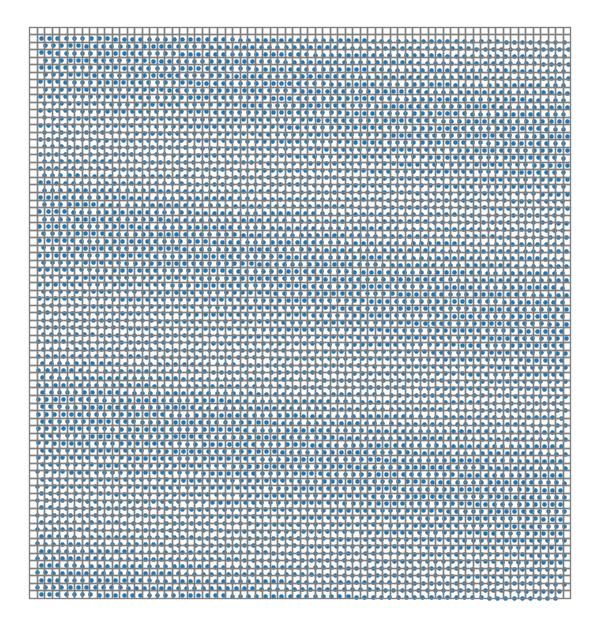

In [17]:
ax = gdf.plot(markersize=5, figsize=(12, 8))
plt.autoscale(False)
cell.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off")

In [18]:
gdf

,geometry,radius
0,POINT (4131.000 4636.000),63.917904
1,POINT (13355.000 16640.000),63.917904
2,POINT (8845.000 12067.000),63.917904
3,POINT (14716.000 15518.000),63.917904
4,POINT (11404.000 12365.000),63.917904
...,...,...
4987,POINT (8731.000 9049.000),63.917904
4988,POINT (6598.000 4776.000),63.917904
4989,POINT (10447.000 6653.000),63.917904
4990,POINT (11039.000 12368.000),63.917904


In [19]:
sdata_grid = SpatialData(shapes={"grid": ShapesModel.parse(gdf)})

In [20]:
visium_sdata.shapes['grid'] = ShapesModel.parse(gdf)

In [21]:
gridium = visium_sdata.aggregate(
    by="grid",
    value_key=["ADAM9"], # value keys to be defined
    values="CytAssist_FFPE_Human_Breast_Cancer",
    target_coordinate_system="global",
)

/home/dbdimitrov/anaconda3/envs/spatialdata/lib/python3.10/site-packages/spatialdata/_utils.py:209: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical = pd.api.types.is_categorical_dtype(obs[column])
/home/dbdimitrov/anaconda3/envs/spatialdata/lib/python3.10/site-packages/spatialdata/_utils.py:212: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  obs[column] = c
/home/dbdimitrov/anaconda3/envs/spatialdata/lib/python3.10/site-packages/spatialdata/_core/operations/aggregate.py:369: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  categorical = pd.api.types.is_categorical_dtype(actual_values.iloc[:, 0])
/home/dbdimitrov/anaconda3/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is d

In [22]:
# from spatialdata import save_transformations

# save_transformations(visium_sdata)
# save_transformations(xenium_sdata)

SET!

In [23]:
set_transformation(visium_sdata.shapes['CytAssist_FFPE_Human_Breast_Cancer'], affine, 'aligned')

In [24]:
visium_sdata = visium_sdata.transform_to_coordinate_system('aligned')

In [25]:
set_transformation(gridium.shapes['grid'], affine, 'aligned')
gridium = gridium.transform_to_coordinate_system('aligned')

In [26]:
xenium_sdata.add_shapes("grid", gridium.shapes['grid'], overwrite=True)

In [27]:
np.intersect1d(xenium_sdata.table.var.index, visium_sdata.table.var.index)[0:20]

array(['ABCC11', 'ACTA2', 'ACTG2', 'ADAM9', 'ADGRE5', 'ADH1B', 'ADIPOQ',
       'AGR3', 'AHSP', 'AIF1', 'AKR1C3', 'ALDH1A3', 'ANKRD28', 'ANKRD29',
       'ANKRD30A', 'APOBEC3A', 'APOBEC3B', 'APOC1', 'AQP1', 'AQP3'],
      dtype=object)

Aggregate points by shape

In [28]:
# xenium_sdata['transcripts'].compute()

In [29]:
# set_transformation(xenium_sdata.points['transcripts'], affine, 'aligned')

# xenium_grid = xenium_sdata.aggregate(
#     values="transcripts",
#     by="grid",
#     value_key=["feature_name"], # value keys to be defined
#     target_coordinate_system="aligned",
# )

Transform to Grid

In [38]:
from spatialdata.transformations import (
    Affine,
    Identity,
    MapAxis,
    Scale,
    Sequence,
    Translation,
    get_transformation,
    get_transformation_between_coordinate_systems,
    set_transformation,
)

In [39]:
xenium_sdata.shapes['grid'].total_bounds

array([  132.09562257,  1208.18522038, 33358.52059827, 32859.54662596])

In [46]:
map_axis = MapAxis({"x": "y", "x": "y"})

In [47]:
set_transformation(xenium_sdata.shapes['cell_circles'], map_axis, 'aligned')
set_transformation(xenium_sdata.shapes['grid'], map_axis, 'aligned')


In [48]:
get_transformation(xenium_sdata.shapes['cell_circles'], get_all=True)

{'global': Scale (x, y)
     [4.70588235 4.70588235],
 'aligned': MapAxis 
     x <- y}

In [49]:
xenium_grid = xenium_sdata.aggregate(
    by="grid",
    value_key=["ADAM9"], # value keys to be defined
    values="cell_circles",
    target_coordinate_system="aligned",
)

WARNING  The transformation matrix is not isotropic, the radius will be scaled by the average of the eigenvalues of
         the affine transformation matrix                                                                          
WARNING  The transformation matrix is not isotropic, the radius will be scaled by the average of the eigenvalues of
         the affine transformation matrix                                                                          


/home/dbdimitrov/anaconda3/envs/spatialdata/lib/python3.10/site-packages/spatialdata/_utils.py:209: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical = pd.api.types.is_categorical_dtype(obs[column])
/home/dbdimitrov/anaconda3/envs/spatialdata/lib/python3.10/site-packages/spatialdata/_utils.py:212: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  obs[column] = c
/home/dbdimitrov/anaconda3/envs/spatialdata/lib/python3.10/site-packages/spatialdata/_core/operations/aggregate.py:369: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  categorical = pd.api.types.is_categorical_dtype(actual_values.iloc[:, 0])
/home/dbdimitrov/anaconda3/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is d

In [50]:
xenium_sdata.shapes['cell_circles'].total_bounds

array([2.13251610e+00, 1.36715559e+00, 7.52308687e+03, 5.47626611e+03])

In [ ]:
# plot geopandas dataframe
xenium_sdata.shapes['grid'].plot()

In [ ]:
gridium.shapes['grid'].plot()

In [ ]:
xenium_grid.shapes['grid'].total_bounds

In [ ]:
from matplotlib import pyplot as plt
plt.hist(xenium_grid.table.X.A)

In [ ]:
xenium_sdata.table[:, ["ADAM9"]].X.sum()

In [ ]:
np.sum(xenium_grid.table.X)

In [ ]:
import spatialdata_plot


In [ ]:
xenium_sdata.pl.render_images().pl.render_shapes('xenium_landmarks').pl.show()

Process

In [ ]:
sc.pp.filter_cells(visium_sdata.table, min_genes=200)
sc.pp.filter_genes(visium_sdata.table, min_cells=3)
sc.pp.normalize_total(visium_sdata.table)
sc.pp.log1p(visium_sdata.table)
# sc.pp.pca(visium_sdata.table)
# sc.pp.neighbors(visium_sdata.table)

In [ ]:
sq.pl.spatial_scatter(visium_sdata.table, color="FOXA1", img=False, size=size)

In [ ]:
sc.pp.filter_cells(xenium_sdata.table, min_genes=10)
sc.pp.filter_genes(xenium_sdata.table, min_cells=3)
sc.pp.normalize_total(xenium_sdata.table)
sc.pp.log1p(xenium_sdata.table)

In [ ]:
sq.pl.spatial_scatter(xenium_sdata.table, shape=None, color="FOXA1", img=False)

In [ ]:
# only keep genes that are found in both datasets
common_genes = np.intersect1d(visium_sdata.table.var_names, xenium_sdata.table.var_names)
visium = visium_sdata.table[:, common_genes].copy()
xenium = xenium_sdata.table[:, common_genes].copy()

In [ ]:
from mudata import MuData

In [ ]:
import liana as li

In [ ]:
visium = visium[~np.isnan(visium.obsm['spatial']).any(axis=1)]

In [ ]:
mdata = MuData({"intra":visium, "extra":xenium})

In [ ]:
mdata

In [ ]:
p, df = li.ut.query_bandwidth(coordinates=visium.obsm['spatial'], interval_n=20, start=0, end=1000)

In [ ]:
p

In [ ]:
p, df = li.ut.query_bandwidth(coordinates=visium.obsm['spatial'], reference=xenium.obsm['spatial'], interval_n=20, start=0, end=1500)

In [ ]:
p

In [ ]:
li.ut.spatial_neighbors(xenium, bandwidth=1500, cutoff=0.1, spatial_key="spatial", reference=visium.obsm['spatial'], max_neighbours=500, set_diag=False, standardize=False)

In [ ]:
misty = li.mt.MistyData(mdata, enforce_obs=False, obs=mdata.obs)

In [ ]:
misty.mod['intra'] = misty.mod['intra'][:,0:25]

In [ ]:
misty

In [ ]:
misty(model='linear', verbose=True, bypass_intra=True)

In [ ]:
misty.uns['target_metrics'].sort_values("multi_R2")